# 바이트 페어 인코딩

**BPE**
- 1994년 제안된 정보 압축 알고리즘
- 데이터에서 가장 많이 등장한 문자열 병합해서 데이터 압축하는 기법
- 사전의 크기를 지나치게 늘리지 않으면서도 데이터 길이 효율적으로 압축 

**BPE 토큰화 절차**
- 어휘 집합 구축 : 자주 등장하는 문자열 병합하고 어휘 집합에 추가. 원하는 어휘 집합 크기가 될 때까지 반복
- 토큰화 : 토큰화 대상 문장의 각 어절에서 어휘 집합에 있는 서브워드가 포함되었을 때 해당 서브워드를 어절에서 분리

**BPE 어휘 집합 구축**
- 어휘 집합을 만들려면 우선 말뭉치 준비해야 함 
- 프리토크나이즈 : 말뭉치의 모든 문장 공백으로 나눔(공백 말고 다른 기준으로 가능)
- 바이그램 쌍으로 나열하고 같은 바이그램 쌍 합치기(병합 우선순위) => 가장 많이 등장한 바이그램 쌍 합친 것 어휘 집합에 추가 => 사용자가 정한 크기가 될 때까지 반복


**BPE 토큰화**
- 어휘 집합과 병합 우선순위가 있으면 수행 가능 
- unk 미등록 토큰 
- 미등록 토큰이 발생하는 경우는 많지 않음 

## GPT 토크나이저 구축

In [5]:
# !pip install ratsnlp
# !pip install Korpora

# 오픈소스 파이썬 패키지 코포라 활용해 BPE 수행 대상 말뭉치 내려받고 전처리
# 실습용 말뭉치는 네이버 영화 NSMC
from Korpora import Korpora
nsmc = Korpora.load("nsmc", force_download=True)

# NSMC 전처리
import os 
def write_lines(path, lines):
    with open(path, 'w', encoding='utf-8') as f:
        for line in lines:
            f.write(f'{line}\n')
write_lines('train.txt', nsmc.train.get_all_texts())
write_lines('test.txt', nsmc.test.get_all_texts())


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



[nsmc] download ratings_train.txt: 14.6MB [00:01, 8.36MB/s]                                                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 6.61MB/s]                                                             


In [10]:
# !pip install tokenizers

# 디렉터리 만들기
import os 
os.makedirs('bbpe', exist_ok=True)

# 바이트 수준 BPE 어휘 집합 구축
from tokenizers import ByteLevelBPETokenizer
bytebpe_tokenizer = ByteLevelBPETokenizer()
bytebpe_tokenizer.train(
    files=['train.txt', 'test.txt'], # 학습 말뭉치를 리스트 형태로 넣기
    vocab_size=10000, # 어휘 집합 크기 조절
    special_tokens=["[PAD]"] # 특수 토큰 추가
    )
bytebpe_tokenizer.save_model('bbpe')

['bbpe\\vocab.json', 'bbpe\\merges.txt']

### 성공 결과

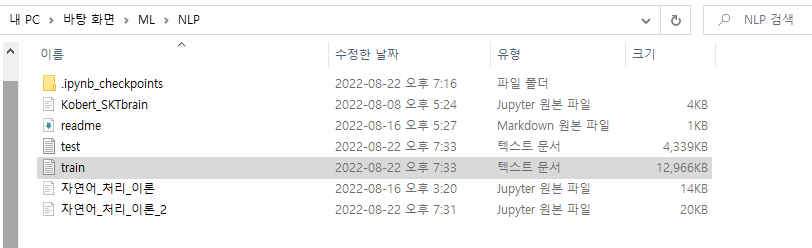

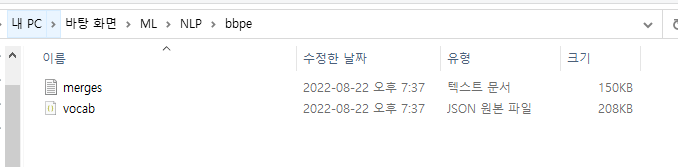

## GPT 토큰화

- 인덱싱 : 각 토큰을 인텍스로 변환하는 과정 
- [PAD] 토큰은 더미 토큰으로 길이 맞춰주는 역할 

In [19]:
# !pip install transformers

# GPT 토크나이저 선언
from transformers import GPT2Tokenizer
tokenizer_gpt = GPT2Tokenizer.from_pretrained('bbpe')
tokenizer_gpt.pad_token = "[PAD]"

# GPT 토크나이저로 토큰화하기
sentences = [
    "아 더빙.. 진짜 짜증나네요 목소리",
    "흠...포스터보고 초딩영환줄....오버연기조차 가볍지 않구나",
    "별루 였다.."
]
tokenizer_sentences = [tokenizer_gpt.tokenize(sentence) for sentence in sentences]
# tokenizer_sentences

# GPT 모델 입력 만들기
batch_inputs = tokenizer_gpt(
    sentences,
    padding='max_length', # 문장의 최대 길이에 맞춰 패딩
    max_length=12, # 문장의 토큰 기준 최대 길이
    truncation=True, # 문장 잘림 허용 옵션 
)

# 토큰화 결과를 가지고 각 토큰 인덱스로 바꾼 것 
batch_inputs["input_ids"] 

# attention_mask
# 일반 토큰이 자리한 곳과 패딩 토큰이 자리한 곳 구분해 알려줌
batch_inputs["attention_mask"]

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

# 워드피스

**워드피스**
- 말뭉치에서 자주 등장한 문자열을 토큰으로 인식
- 문자열을 병합했을 때 말뭉치의 우도를 가장 높이는 쌍 병합 
- 병합 후보에 오른 쌍을 미리 병합해 보고 잃는 것과 가치 등을 판단한 후에 병합
- 어휘 집합만 가지고 토큰화

# BERT 토크나이저 구축

In [21]:
# 디렉터리 만들기
import os 
os.makedirs('wordpiece', exist_ok=True)

# 바이트 수준 BPE 어휘 집합 구축
from tokenizers import BertWordPieceTokenizer
wordpiece_tokenizer = BertWordPieceTokenizer()
wordpiece_tokenizer.train(
    files=['train.txt', 'test.txt'], # 학습 말뭉치를 리스트 형태로 넣기
    vocab_size=10000, # 어휘 집합 크기 조절
    )
wordpiece_tokenizer.save_model('wordpiece')

['wordpiece\\vocab.txt']

## 성공 결과

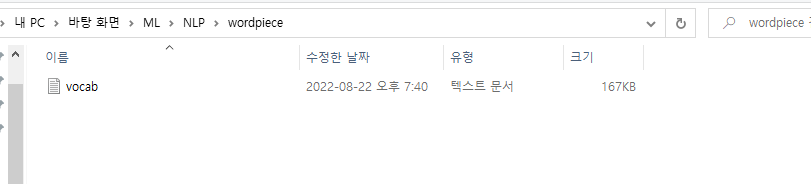

## BERT 토큰화

In [24]:
# BERT 토크나이저 선언
from transformers import BertTokenizer
tokenizer_bert = BertTokenizer.from_pretrained(
    'wordpiece',
    do_lower_case=False,
)

# BERT 토크나이저로 토큰화하기
sentences = [
    "아 더빙.. 진짜 짜증나네요 목소리",
    "흠...포스터보고 초딩영환줄....오버연기조차 가볍지 않구나",
    "별루 였다.."
]

tokenizer_sentences = [tokenizer_bert.tokenize(sentence) for sentence in sentences]
# tokenizer_sentences

# BERT 모델 입력 만들기
batch_inputs = tokenizer_bert(
    sentences,
    padding='max_length', # 문장의 최대 길이에 맞춰 패딩
    max_length=12, # 문장의 토큰 기준 최대 길이
    truncation=True, # 문장 잘림 허용 옵션 
)

# 토큰화 결과를 가지고 각 토큰 인덱스로 바꾼 것 
batch_inputs["input_ids"] 

# attention_mask
# 일반 토큰이 자리한 곳과 패딩 토큰이 자리한 곳 구분해 알려줌
batch_inputs["attention_mask"]

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]

# 미리 학습된 언어모델

- BERT, GPT 모델 주목 이유는 성능 때문
- 이 모델들 사용하면 문서 분류, 개체명 인식 등 어떤 태스크든지 점수 이전과 비교해 큰 폭으로 오름

**언어 모델**
- 단어 시퀀스에 확률을 부여하는 모델
- 단어 시퀀스를 입력받아 해당 시퀀스가 얼마나 그럴듯한지 확률 출력하는 모델
- 이전 단어들이 주어졌을 때 다음 단어가 나타날 확률을 부여하는 모델

**순방향 언어 모델**
- 이전 단어들(컨텍스트)이 주어졌을 때 다음 단어 맞히기
- 문장 앞부터 뒤로, 사람이 이해하는 순서대로 계산하는 모델
- GPT, ELMo

**역방향 언어 모델**
- 문장 뒤부터 앞으로 계산
- ELMo

**넓은 의미의 언어 모델**
- 컨텍스트(주변 맥락 정보)가 전제된 상태에서 특정 단어가 나타날 조건부 확률

**마스크 언어 모델**
- 학습 대상 문장에 빈칸을 만들어 놓고 해당 빈칸에 올 단어로 적절한 단어가 무엇일지 분류하는 과정으로 학습
- BERT
- 맞힐 단어를 계산할 때 문장 전체의 맥락 참고 가능 
- 양방향 성질. 맞힐 단어 앞뒤를 모두 봄

**스킵-그램 모델**
- 어떤 단어 앞뒤에 특정 범위를 정해 두고 이 범위 내에 어떤 단어들이 올지 분류하는 과정으로 학습
- Word2Vec

**언어 모델의 유용성**
- 기계 번역, 문법 교정, 문장 생성 
- 잘 학습된 언어 모델은 어떤 문장이 자연스러운지 가려낼 수 있음 

**언어 모델 주목 이유**
- 데이터 제작 비용 때문
- 다음 단어 맞히기, 빈칸 맞히기 등으로 학습 태스크 구성하면 사람이 일일이 수작업해야 하는 레이블 없이도 많은 학습 데이터 싼값에 만들 수 있음 
- 트랜스퍼 러닝 때문
- 대량의 말뭉치로 프리트레인한 언어 모델을 문서 분류, 개체명 인시